# 1.1 Stereo Vision

### 1.1.1 Block Matching


In [ ]:
def Block_Matching_Stereo(left_image, right_image, block_size=1, cost_type='ssd'):
    height, width = left_image.shape

    # Initialize disparity map
    disparity_map = np.zeros_like(left_image, dtype=np.float32)

    # Iterate over each pixel in the left image
    for y in range(block_size // 2, height - block_size // 2):
        for x in range(block_size // 2, width - block_size // 2):

            block_left = left_image[y - block_size // 2: y + block_size // 2 + 1,
                                    x - block_size // 2: x + block_size // 2 + 1]

            min_cost = float('inf')
            best_disparity = 0

            # Iterate over each pixel in the corresponding row of the right image
            for x_right in range(block_size // 2, x - block_size // 2):
                block_right = right_image[y - block_size // 2: y + block_size // 2 + 1,
                                          x_right - block_size // 2: x_right + block_size // 2 + 1]

                if cost_type == 'ssd':
                    cost = np.sum((block_left - block_right) ** 2)
                elif cost_type == 'sad':
                    cost = np.sum(np.abs(block_left - block_right))
                else:
                    raise ValueError("Invalid cost_type. Use 'ssd' or 'sad'.")

                if cost < min_cost:
                    min_cost = cost
                    best_disparity = x - x_right

            disparity_map[y, x] = best_disparity

    return disparity_map


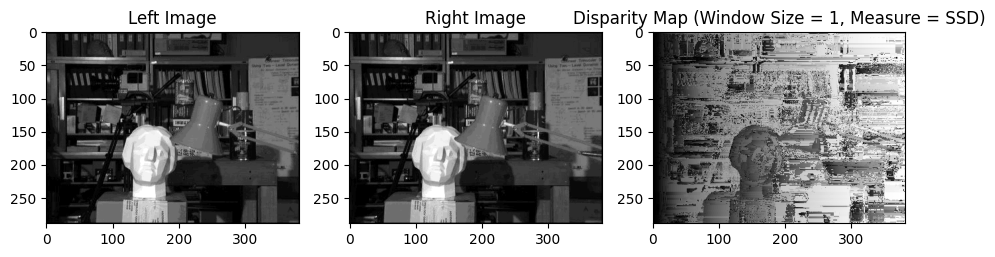

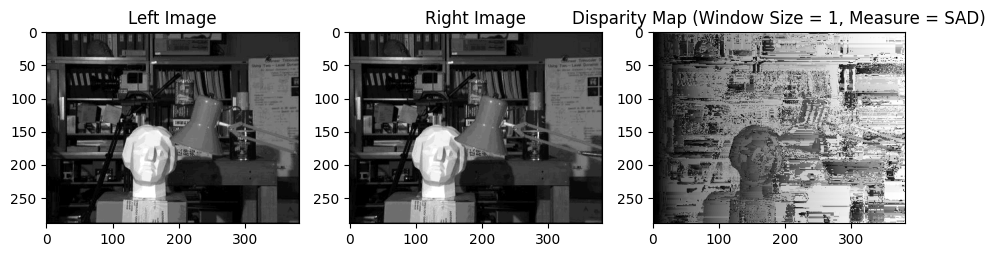

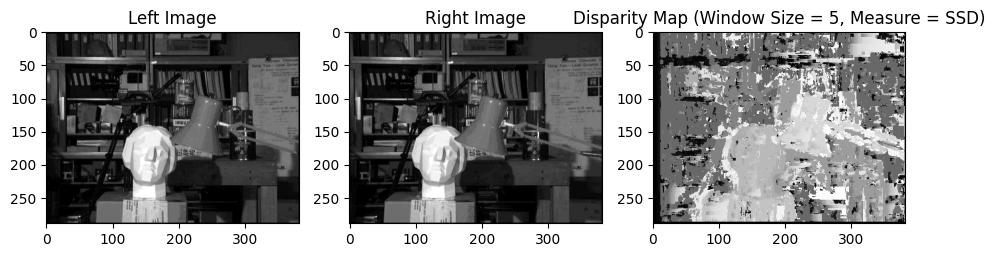

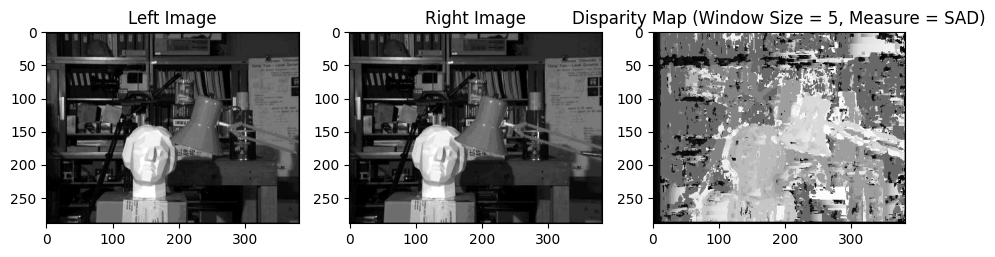

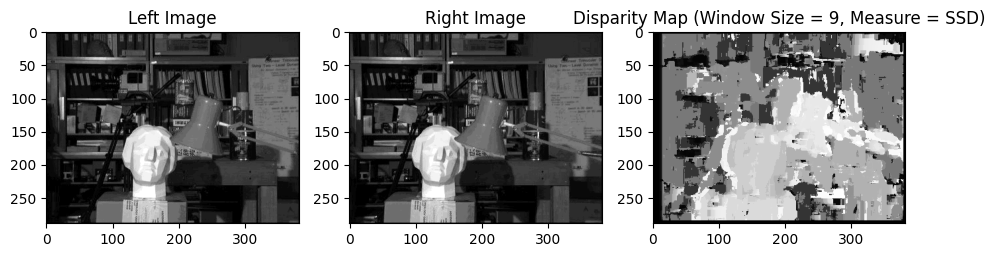

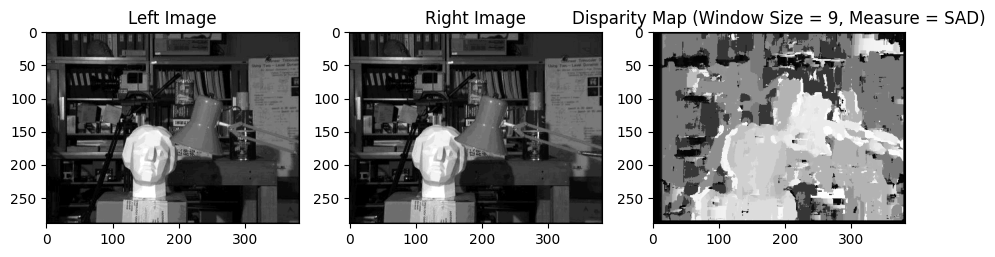

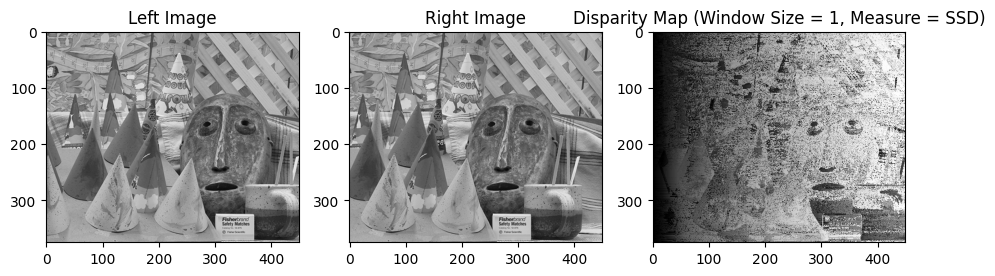

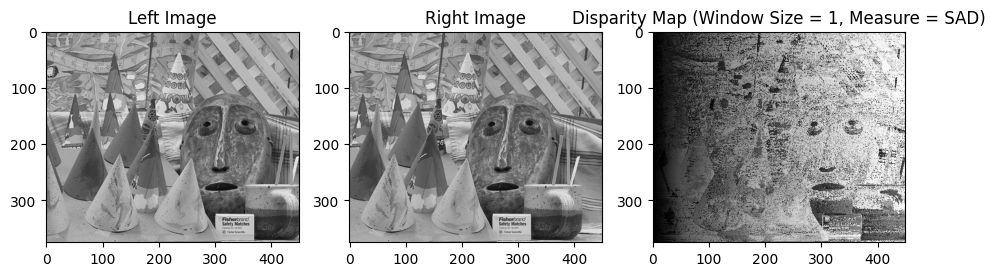

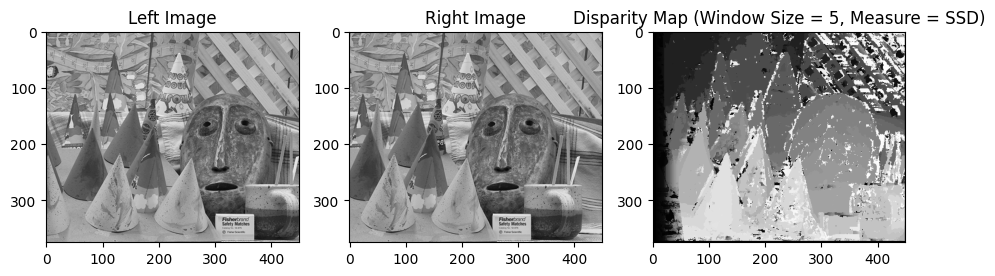

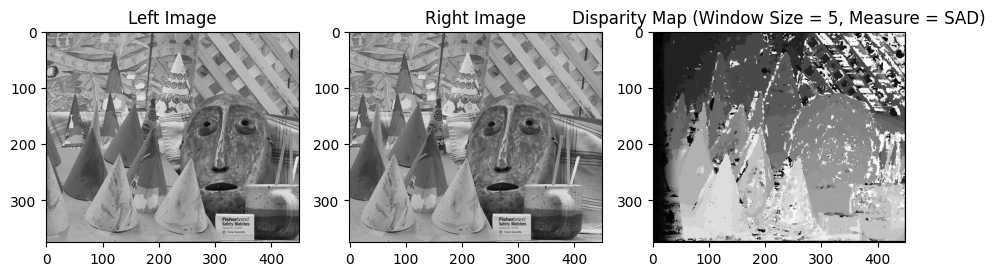

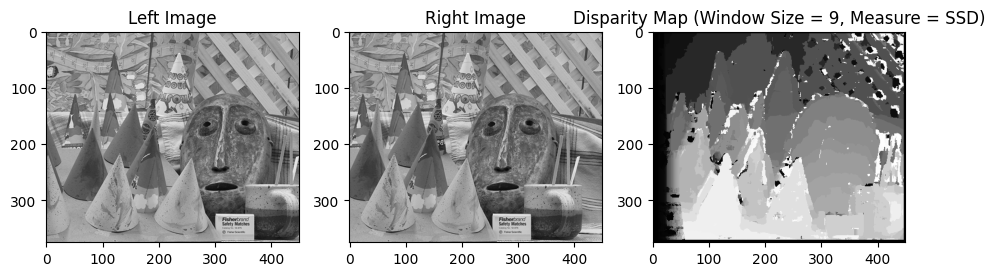

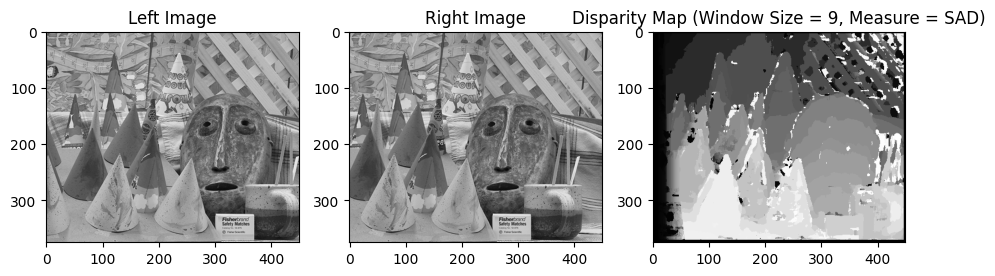

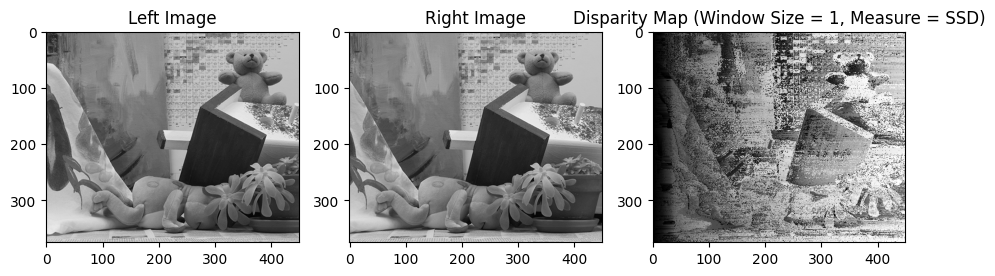

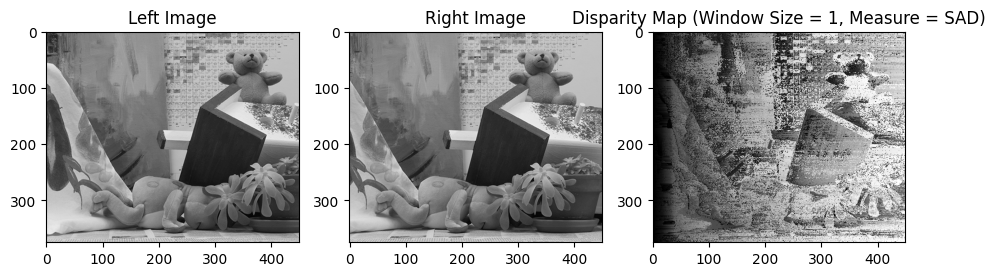

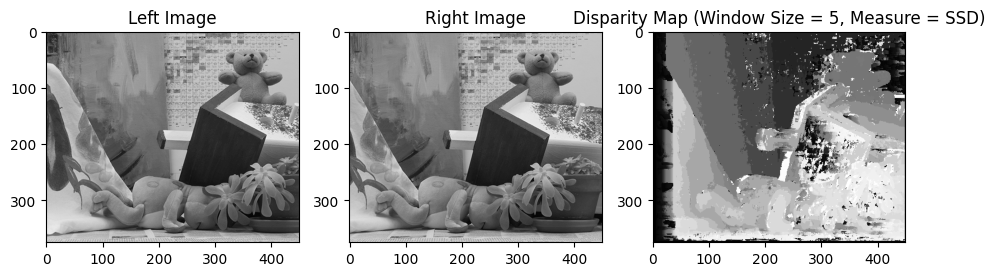

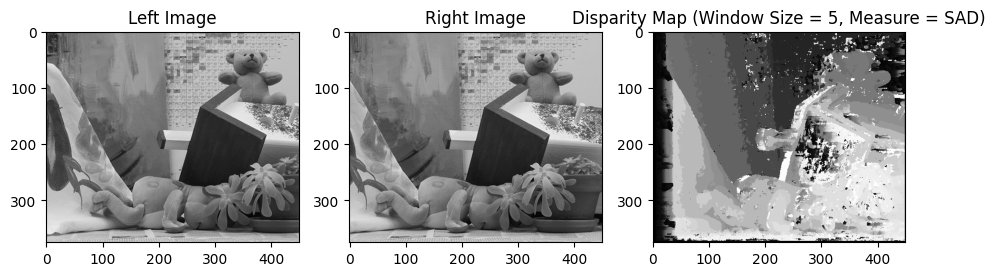

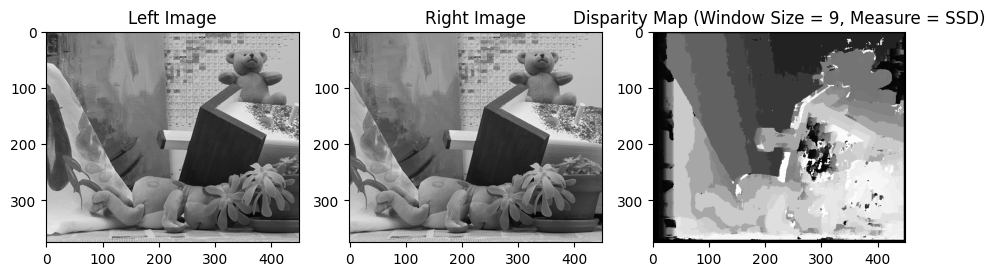

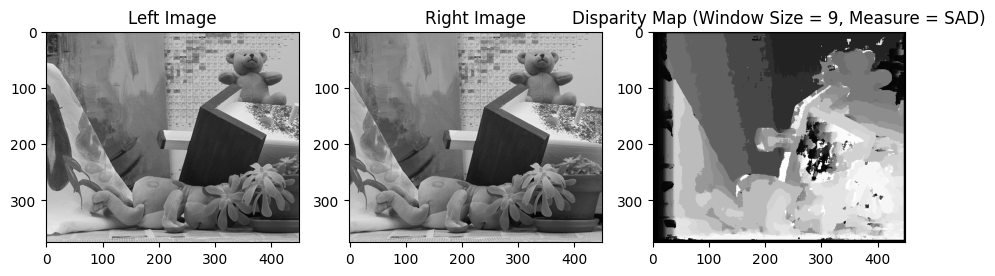

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_paths = ['/content/l1.png', '/content/r1.png', '/content/l2.png', '/content/r2.png', '/content/l3.png', '/content/r3.png']

# Different window sizes
window_sizes = [1, 5, 9]

# Loop over the image pairs
for i in range(0, len(image_paths), 2):
    # Load the stereo images
    left_image = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(image_paths[i + 1], cv2.IMREAD_GRAYSCALE)

    # Convert images to float32 for processing
    left_image = left_image.astype(np.float32)
    right_image = right_image.astype(np.float32)

    # Loop over different window sizes
    for window_size in window_sizes:
        # Loop over different similarity measures (SSD, SAD)
        for similarity_measure in ['ssd', 'sad']:
            # Perform block matching stereo
            disparity_map = Block_Matching_Stereo(left_image, right_image, block_size=window_size,cost_type=similarity_measure)

            # Normalize the disparity map for display
            disparity_map_normalized = cv2.normalize(disparity_map, disparity_map, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)


            disparity_map_equalized = cv2.equalizeHist(disparity_map_normalized.astype(np.uint8))

            # Display the images and disparity map using Matplotlib
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 4, 1)
            plt.imshow(left_image, cmap='gray')
            plt.title('Left Image')

            plt.subplot(1, 4, 2)
            plt.imshow(right_image, cmap='gray')
            plt.title('Right Image')

            plt.subplot(1, 4, 3)
            plt.imshow(disparity_map_equalized, cmap='gray')
            plt.title(f'Disparity Map (Window Size = {window_size}, Measure = {similarity_measure.upper()})')

            plt.show()

### 1.1.2 Dynamic programming

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!gdown 1VxmBPuqo_QYzDnpW2e-igJABJLonRKKP -O l1.png
!gdown 1yMepdE2Ni8-PiykZ-xgaSAn9aCysw2tL -O l2.png
!gdown 1S-oNW8Hlz-Li3Ch1sSroQD6Ob4ru8tSs -O l3.png
!gdown 1zXul6GE1Fg5BrEvkCnmf3zKLOoRkB4__ -O r1.png
!gdown 1HJydN0g8FpJ6txNwdx2mF5TrIN-boOFj -O r2.png
!gdown 1gdIgKfMJzQtvymukg8GijqFyB3dRTfL5 -O r3.png

Downloading...
From: https://drive.google.com/uc?id=1VxmBPuqo_QYzDnpW2e-igJABJLonRKKP
To: /content/l1.png
100% 111k/111k [00:00<00:00, 19.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yMepdE2Ni8-PiykZ-xgaSAn9aCysw2tL
To: /content/l2.png
100% 363k/363k [00:00<00:00, 82.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S-oNW8Hlz-Li3Ch1sSroQD6Ob4ru8tSs
To: /content/l3.png
100% 342k/342k [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zXul6GE1Fg5BrEvkCnmf3zKLOoRkB4__
To: /content/r1.png
100% 111k/111k [00:00<00:00, 74.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HJydN0g8FpJ6txNwdx2mF5TrIN-boOFj
To: /content/r2.png
100% 364k/364k [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gdIgKfMJzQtvymukg8GijqFyB3dRTfL5
To: /content/r3.png
100% 343k/343k [00:00<00:00, 116MB/s]


In [ ]:
# Calculate the cost of matching pixels il and ir based on squared error.
def get_cost(il, ir, sigma=2):
    squared_error = np.square(np.subtract(il, ir) / sigma)
    return squared_error

In [ ]:
# Compute the disparity map using a dynamic programming algorithm
def compute_disparity_dp(left_image, right_image, sigma=2, c0=1):
    n_rows, n_columns = left_image.shape
    disparity = np.zeros((n_rows, n_columns), dtype=np.float128)
    for row in range(n_rows):
        dp = np.full((n_columns + 1, n_columns + 1), np.inf)
        dp[1][1] = get_cost(left_image[row][0], right_image[row][0], sigma)
        # Dynamic programming to compute optimal alignment
        for i in range(1, n_columns + 1):
            for j in range(1, n_columns + 1):
                if i == 1 and j == 1:
                    continue
                dp[i][j] = min(dp[i-1][j-1] + get_cost(left_image[row][i - 1], right_image[row][j - 1], sigma),
                                  dp[i-1][j] + c0,
                                  dp[i][j-1] + c0)

        i, j = n_columns, n_columns
        disparity_map = np.zeros((n_columns, n_columns))
        # Backtracking to find optimal alignment
        while i > 0 and j > 0:
            if dp[i][j] == (dp[i - 1][j - 1] + get_cost(left_image[row][i - 1], right_image[row][j - 1], sigma)):
                disparity_map[i-2][j-2] = 1
                disparity[row][i - 1] = np.abs(i - j)
                i -= 1
                j -= 1
            elif dp[i][j] == dp[i - 1][j] + c0:
                disparity_map[i-2][j-1] = 1
                i -= 1
            else:
                disparity_map[i-1][j-2] = 1
                j -= 1
    return disparity * 255 / np.max(disparity), disparity_map * 255

In [ ]:
left_images = []
right_images = []
disparity_images = []
disparity_maps = []

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


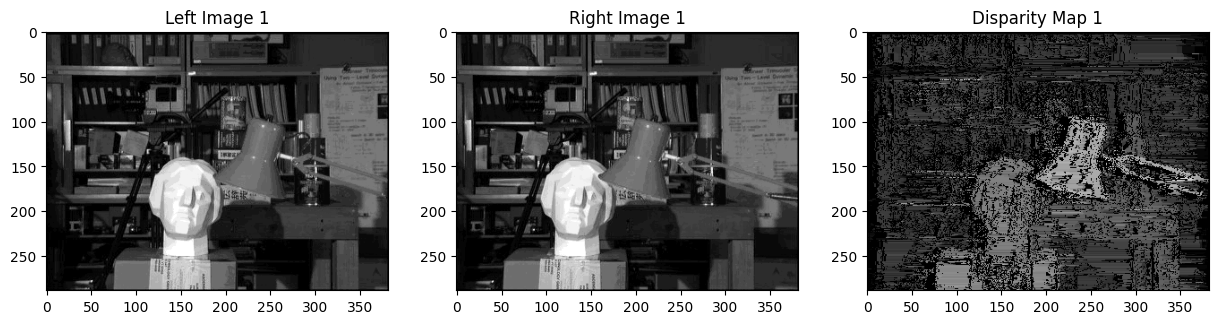

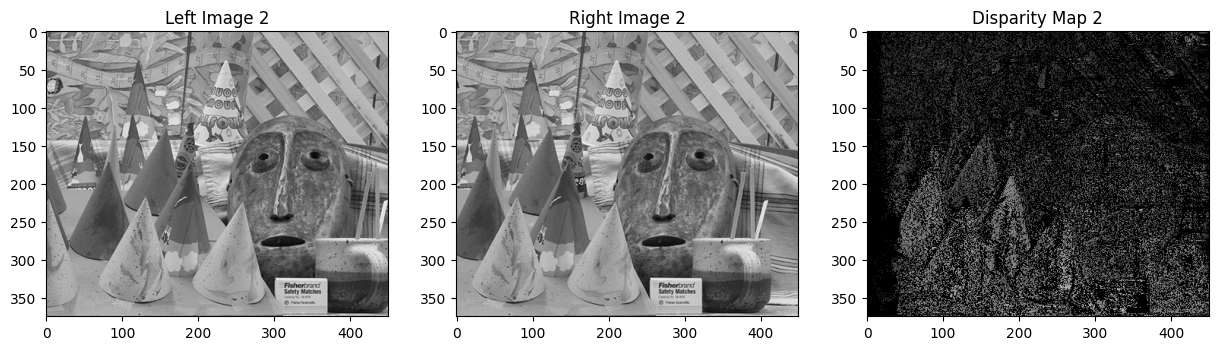

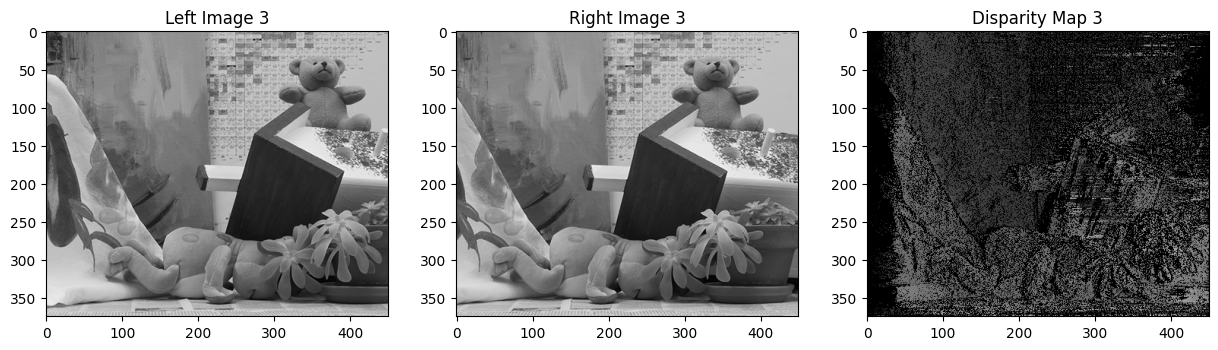

In [ ]:
# Load images and compute disparity maps for each i
for i in range(3):
    left_images.append(cv2.imread(f'l{i + 1}.png', cv2.IMREAD_GRAYSCALE))
    right_images.append(cv2.imread(f'r{i + 1}.png', cv2.IMREAD_GRAYSCALE))
    disparity_img, disparity_map = compute_disparity_dp(left_images[-1], right_images[-1])
    disparity_images.append(disparity_img)
    disparity_maps.append(disparity_map)

    # Plot the left, right, and disparity images for the current i
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(left_images[-1], cmap='gray')
    plt.title(f'Left Image {i + 1}')

    plt.subplot(1, 3, 2)
    plt.imshow(right_images[-1], cmap='gray')
    plt.title(f'Right Image {i + 1}')

    plt.subplot(1, 3, 3)
    plt.imshow(disparity_img, cmap='gray')
    plt.title(f'Disparity Map {i + 1}')

    plt.show()

# 1.2 Bonus

In [ ]:
def get_scan_line(left_image, right_image, disparity_map):
    # Get the dimensions of the left image
    n_rows, n_columns = left_image.shape

    # Create the left part of the scan line by concatenating the last row of the left image and the disparity map
    left_image_part = np.concatenate((np.repeat([left_image[n_rows - 1]], 15, axis=0).T, disparity_map), axis=1)

    # Create the right part of the scan line by concatenating zeros and the last row of the right image
    right_image_part = np.concatenate((np.repeat([np.zeros(15)], 15, axis=0),
                                        np.repeat([right_image[n_rows - 1]], 15, axis=0)), axis=1)

    # Concatenate the left and right parts to form the complete scan line
    scan_line = np.concatenate((left_image_part, right_image_part))

    return scan_line

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


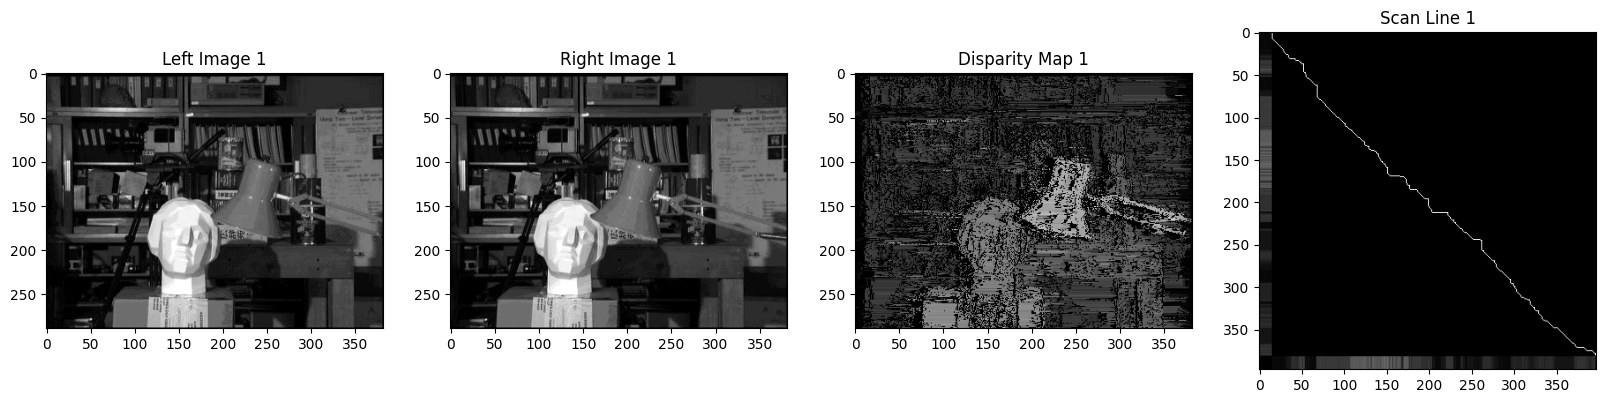

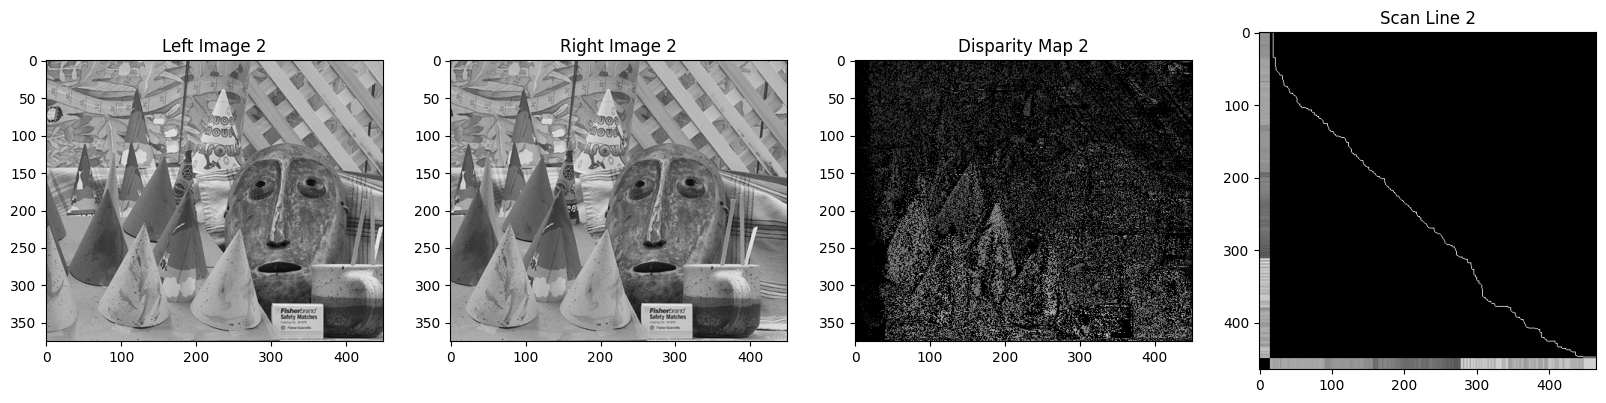

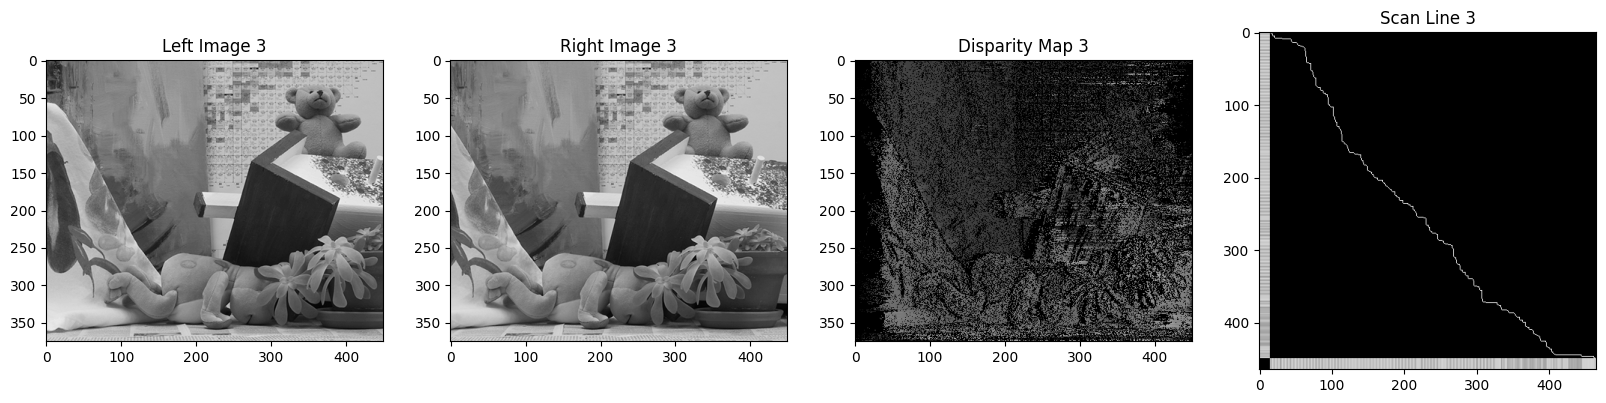

In [ ]:
for i in range(3):
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 4, 1)
    plt.imshow(left_images[i], cmap='gray')
    plt.title(f'Left Image {i + 1}')

    plt.subplot(1, 4, 2)
    plt.imshow(right_images[i], cmap='gray')
    plt.title(f'Right Image {i + 1}')

    plt.subplot(1, 4, 3)
    plt.imshow(disparity_images[i], cmap='gray')
    plt.title(f'Disparity Map {i + 1}')

    plt.subplot(1, 4, 4)
    plt.imshow(get_scan_line(left_images[i], right_images[i], disparity_maps[i]), cmap='gray')
    plt.title(f'Scan Line {i + 1}')

    plt.show()